In [18]:
import numpy as np
import matplotlib.pyplot as plt

### Process Model

In [11]:
# give an example here first
v_sb_b = np.array([2, 2, 0])
w_sb_b = np.array([0, 0, 3])
bp = np.array([2, 1, 0])

In [12]:
v_bpc_b = np.zeros((3, ))
v_bpc_b

array([0., 0., 0.])

$$
v_{bp_c}^b=-v_{sb}^b+-w_{sb}^b\times b_p = -\begin{bmatrix}
 \mathbf{I} & \left [ \mathbf{p_c} \right ] 
\end{bmatrix}\begin{bmatrix}
v_{sb}^b \\ w_{sb}^b
\end{bmatrix}
$$

Direct cross product

In [13]:
v_bpc_b = -v_sb_b + -np.cross(w_sb_b, bp)
print(-v_sb_b, -np.cross(w_sb_b, bp), v_bpc_b)

[-2 -2  0] [ 3 -6  0] [ 1 -8  0]


skew-symmetric matrix 

In [14]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])
np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [20]:
I = np.identity(3)
pc_ = -skew(bp) # should be negative
B = -np.append(I, pc_, axis=1)
xi = np.append(v_sb_b, w_sb_b, axis=0)
xi.transpose(),xi, B

(array([2, 2, 0, 0, 0, 3]),
 array([2, 2, 0, 0, 0, 3]),
 array([[-1., -0., -0., -0., -0.,  1.],
        [-0., -1., -0., -0., -0., -2.],
        [-0., -0., -1., -1.,  2., -0.]]))

In [19]:
B @ xi

array([ 1., -8.,  0.])

WHYYYYYYYYY!!!!

$$
    \mathbf{a} \times \mathbf{b} = - \left ( \mathbf{b} \times \mathbf{a} \right ) 
$$

State transition function

In [22]:
def f_contact(x, lv, av, dt):
    input = np.append(lv, av, axis=0)
    B = -dt*np.append(np.identity(3), -skew(x), axis=1)
    A = np.identity(3)
    prior_predict = A @ x + B @ input 
    return prior_predict

In [23]:
f_contact(np.array([1, 1, 0]), lv=v_sb_b, av=w_sb_b, dt=1)

array([ 2., -4.,  0.])

### Measurement Model

5-order bivariate polynomial model

In [79]:
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y, copy=False) # meshgrid ? dimension to 400
X, X.shape

(array([[0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
         0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ],
        [0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
         0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ],
        [0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
         0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ],
        [0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737

In [66]:

Z = X**2 + Y**2 + np.random.rand(*X.shape)*0.01

X = X.flatten()
Y = Y.flatten()

A = np.array([X*0+1, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
B = Z.flatten()

coeff, r, rank, s = np.linalg.lstsq(A, B, rcond=None)

In [50]:
def polyfit2d(x, y, z, kx=3, ky=3, order=None):
    '''
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    '''

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx+1, ky+1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [3]:
import pandas as pd

In [80]:
dataframe = pd.read_excel('FullRangeData.xlsx', sheet_name='Formated_MannulyFixed')
dataframe

,X,Y,Z
0,10,115,3.998222
1,15,115,3.686222
2,20,115,3.374222
3,25,115,3.062222
4,30,115,2.730000
...,...,...,...
165,70,160,-6.110000
166,75,160,-6.095555
167,80,160,-5.936666
168,85,160,-5.618889


In [82]:
z = np.array(dataframe)[:, 2]
z, z.shape

(array([ 3.99822213,  3.68622213,  3.37422214,  3.06222214,  2.72999997,
         2.46999984,  2.12333332,  1.80555549,  1.50944439,  1.19888884,
         0.88111108,  0.51999998,  0.2311111 , -0.07222222, -0.40588887,
        -0.72511108, -1.0443333 ,  4.05586227,  3.77192578,  3.42333317,
         3.17777771,  3.01888874,  2.68666659,  2.38333323,  1.97888882,
         1.55999994,  1.12666663,  0.75111108,  0.31777777,  0.01444444,
        -0.33222221, -0.53444442, -0.86666663, -1.24634916,  4.20539674,
         3.78444441,  3.68333321,  3.42333317,  3.22111109,  2.91777762,
         2.51333316,  2.15222218,  1.57444439,  1.11222218,  0.63555553,
         0.11555555, -0.25999999, -0.66444442, -0.98222219, -1.19888884,
        -1.32888884,  4.21777768,  4.11666648,  4.02999976,  3.76999995,
         3.55333315,  3.23555552,  2.8166666 ,  2.31111105,  1.52388883,
         1.03999996,  0.44777776, -0.15888888, -0.60666664, -1.05444441,
        -1.45888884, -1.55999994, -1.80555549,  4.6

In [96]:
x = np.linspace(10, 90, 17)
y = np.linspace(115, 160, 10)
X, Y = np.meshgrid(x, y)
Y.shape

(10, 17)

In [87]:
coeff, r, rank, s = polyfit2d(x, y, z)

(170, 16) (170,)


(17, 10)


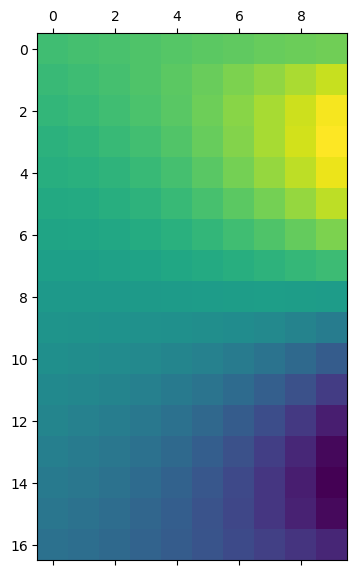

In [98]:
fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((4,4)))
print(fitted_surf.shape)
plt.matshow(fitted_surf)

RMSE

In [ ]:
# fit = np.sum(c[:, None, None] * np.array(get_basis(X, Y, max_order))
#                 .reshape(len(basis), *X.shape), axis=0)

# rms = np.sqrt(np.mean((Z - fit)**2))
# print('RMS residual =', rms)

3D Plot

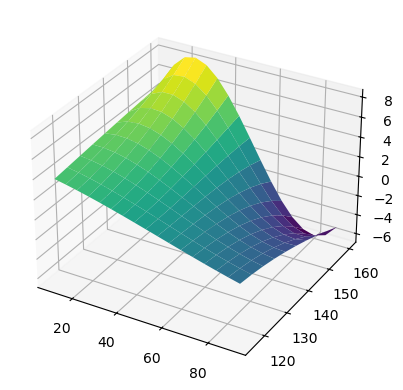

In [101]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, fitted_surf.T, cmap='viridis')
# cset = ax.contourf(X, Y, Z-fitted_surf.T, zdir='z', offset=-4, cmap='viridis')
# ax.set_zlim(-4,np.max(fitted_surf))
plt.show()